# Table of Contents <a id = 'scrollTo=8ZHYR1PYhOvg'></a>

>[Table of Contents](#scrollTo=8ZHYR1PYhOvg)

>>[Introduction](#scrollTo=WJAjUmtVDPhy)
>>>[Import Packages](#scrollTo=6bPDSyZmoGl4)<br>
>>>[Import Data](#scrollTo=f6iVCKMtoAAw)<br>

>>[Data Preparation](#scrollTo=wdZW3n2bPhd-)<br>
>>>[Data feature generation & conversion](#scrollTo=wdZW3n2bPhd-)<br>
>>>[Missing Values](#missing)<br>
>>>[Cross Validation](#cross)<br>
>>>[Hyperparameter Tuning](#hyper)<br>

>>[Modeling Process](#mod)<br>
>>>[Regression Models](#reg)<br>
>>>[Survival Analysis](#survive)<br>

>>[Results](#res)

>>[Group Member Contribution](#grp)

# Introduction <a id = "scrollTo=WJAjUmtVDPhy"></a>

Our objective in this modeling project is to perform survival analysis on maintenance events within an industrial setting, focusing on the time-to-failure and replacement patterns for key equipment components. By analyzing maintenance logs, we aim to identify trends, frequent failure points, and critical functional locations that require frequent interventions, which could inform future predictive maintenance strategies and improve operational efficiency.
Our analytical approach involves several key steps:

- **Data Preprocessing:** We begin by filtering and cleaning the dataset, focusing specifically on unplanned maintenance events and high-frequency parts, such as fillers and valves. This allows us to concentrate on the components that contribute most significantly to operational interruptions.
- **Feature Engineering:** For each maintenance event, we calculate the time-to-event (days between consecutive replacements or failures) and use it as our primary variable of interest in the survival analysis.
- **Survival Analysis and Modeling:** We employ Kaplan-Meier estimators to generate survival curves for the top functional locations with high replacement counts. This reveals the probability of equipment survival over time and highlights the frequency of specific part replacements across different locations.
- **Comparative Analysis:** We conduct pairwise statistical tests (e.g., log-rank tests) to evaluate differences in survival patterns between functional locations, pinpointing sites with higher or lower durability.
- **Insights Generation:** Based on the survival curves and statistical summaries, we draw insights into which equipment and parts have higher failure rates, identifying potential areas for maintenance optimization and component improvements.

## Import Packages <a id = 'scrollTo=6bPDSyZmoGl4'></a>

In [47]:
# Import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from collections import Counter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Import Data <a id = 'scrollTo=f6iVCKMtoAAw'></a>

In [2]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv')

# Data Preparation <a id = 'scrollTo=wdZW3n2bPhd-'></a>

### Data feature generation & conversion <a id = 'scrollTo=wdZW3n2bPhd-'></a>

In [3]:
# Convert numeric data to date type data
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
df['EXECUTION_FINISH_DATE'] = pd.to_datetime(df['EXECUTION_FINISH_DATE'])
df['EQUIP_START_UP_DATE'] = pd.to_datetime(df['EQUIP_START_UP_DATE'])
df['EQUIP_VALID_FROM'] = pd.to_datetime(df['EQUIP_VALID_FROM'])

In [4]:
# Calculate functional duration
df['FUNCTIONAL_DURATION'] =  df['EXECUTION_START_DATE'] - df['EQUIP_VALID_FROM']

This column measures the time between when a machine started being functional (EQUIP_VALID_FROM) and each breakdown’s start date. This metric provides insight into how long each machine typically operates before issues arise, helping to quantify the effect of wear and tear on operational stability.

In [5]:
df.sample(50)

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,FUNCTIONAL_DURATION
574330,610989852,G261,SILVERSTONE,2021-02-09,2021-02-09,14:24:36.000,15:00:22.000,30.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
673691,702616067,G816,COTA,2020-11-27,2020-11-27,07:00:00.000,07:00:00.000,57.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
1043239,1000706391,G261,SILVERSTONE,2019-08-30,2019-08-30,00:00:00.000,00:00:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
455680,170000152824,G261,SILVERSTONE,2017-11-06,2017-11-06,13:15:00.000,13:50:00.000,35.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
978998,700092155,G291,MONZA,2017-09-11,2017-09-11,07:00:00.000,07:00:00.000,6.0,G291VM1432,40529.0,Planned,MODULE OXY CONCENTRATE L1 FOR MECH WHILE,Preventive Maintenance Order,G291-PRD-L30-L01,MONZA PRODUCTION,BTL_PET_LINE,LINE #1 - FILLER_ROT_BTL_PET,NaN,NaN,300001100.0,L1 GAS_GEN_OZONE,Machines,2017-02-15,2023-12-15,9999-12-31,-2286 days
54819,612961024,G261,SILVERSTONE,2023-06-23,2023-07-12,15:30:18.000,21:42:46.000,186.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
929922,701155312,G261,SILVERSTONE,2019-01-28,2019-01-28,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,TIGHTEN EXCESSIVLY LOOSE CUCTION CUP,Corrective Maintenance Order,G261-PRD-L15-L04-L060,SILVERSTONE PRODUCTION,"LINES 3,4,10 - CAN LINES",LINE #4-FILLER_ROTARY_CAN,DEPALLETIZER,NaN,300017319.0,NaN,NaN,NaT,NaT,NaN,NaT
442269,1002054265,G261,SILVERSTONE,2023-08-02,2023-08-02,00:00:00.000,00:00:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT
94981,704720924,G812,ROMA,2023-04-11,2023-04-11,06:00:00.000,06:00:00.000,30.0,NaN,NaN,Unplanned,SEAMER GREASE L3,Corrective Maintenance Order,G812-PRD-L15-L03-L150,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,"SEAMER, ROTARY",NaN,300126810.0,CAN LINE 3 SEAMER,Machines,2020-04-22,2020-02-06,9999-12-31,1160 days
278246,603597874,G811,MONACO,2019-10-15,2019-10-15,12:50:24.000,14:12:55.000,18.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT


In [6]:
# Functional location code split
df['FUCTIONAL_LOC_SPLIT'] = df['FUNCTIONAL_LOC'].str.split('-')

In [7]:
# Select all date columns
date_columns = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE','EQUIP_VALID_FROM']  # replace with actual column names
 
# Stack them into a single series
all_dates = df[date_columns].stack()
 
# Find the latest date
latest_date = all_dates.max()
 
print("The latest date in the dataset is:", latest_date)

The latest date in the dataset is: 2024-08-30 00:00:00


### Missing Values <a id = 'missing'></a>

In [8]:
# Check for missing values
df.isnull().sum() / len(df) * 100

ORDER_ID                            0.000000
PLANT_ID                            0.000000
PRODUCTION_LOCATION                 0.000000
EXECUTION_START_DATE                0.000000
EXECUTION_FINISH_DATE               0.000000
ACTUAL_START_TIME                   0.000000
ACTUAL_FINISH_TIME                  0.000000
ACTUAL_WORK_IN_MINUTES              0.000000
MAINTENANCE_PLAN                   89.308635
MAINTENANCE_ITEM                   89.308635
MAINTENANCE_ACTIVITY_TYPE           0.000000
ORDER_DESCRIPTION                  79.557601
MAINTENANCE_TYPE_DESCRIPTION       79.555639
FUNCTIONAL_LOC                     79.556550
FUNCTIONAL_AREA_NODE_1_MODIFIED    79.673207
FUNCTIONAL_AREA_NODE_2_MODIFIED    80.213401
FUNCTIONAL_AREA_NODE_3_MODIFIED    81.875042
FUNCTIONAL_AREA_NODE_4_MODIFIED    83.354656
FUNCTIONAL_AREA_NODE_5_MODIFIED    99.847260
EQUIPMENT_ID                       79.555639
EQUIPMENT_DESC                     94.433616
EQUIP_CAT_DESC                     94.433616
EQUIP_STAR

Missing value analysis indicates that the column with the highest percentage of missing data is 'FUNCTIONAL_AREA_NODE_5_MODIFIED' (99.8%), followed by 'EQUIPMENT_DESC' and 'EQUIP_START_UP_DATE' (both at 94.4%). These columns contain the most significant gaps, which may impact the comprehensiveness of our analysis in these areas


In [9]:
# Isolate breakdowns by PLANT_ID, LINE_ID, and SUBPROCESS_ID
df['PLANT_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[0]
df['LINE_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[2]
df['SUBPROCESS_ID'] = df['FUCTIONAL_LOC_SPLIT'].str[3]

# Create a machine id which is a combination of all three, here the machine id is the functional location 
df['MACHINE_ID'] = df['PLANT_ID'] + '-' + df['LINE_ID'] + '-' + df['SUBPROCESS_ID']

By isolating breakdowns by PLANT_ID, LINE_ID, and SUBPROCESS_ID, we can identify specific areas within a plant that may require more maintenance or have a higher frequency of issues. This breakdown enables focused interventions at locations with recurrent breakdowns, supporting predictive and preventive maintenance.<br>The Machine ID are not unique identifiers for Machine but says the functional location.

In [10]:
# Calculate machine level aggregations
df_ml = df.groupby('MACHINE_ID').agg(
                             PLANT_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_1_MODIFIED", aggfunc="first"),
                             LINE_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_3_MODIFIED", aggfunc="first"),
                             SUBPROCESS_ID = pd.NamedAgg(column="FUNCTIONAL_AREA_NODE_4_MODIFIED", aggfunc="first"),
                             FIRST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc="min"),
                             SECOND_LAST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc= lambda x: x.sort_values().iloc[-2] if len(x) >= 2 else pd.NaT),
                             LAST_BREAKDOWN =pd.NamedAgg(column="EXECUTION_START_DATE", aggfunc="max"),
                             FIRST_BREAK_DURATION = pd.NamedAgg(column="FUNCTIONAL_DURATION", aggfunc="max"),
                             TOTAL_WORKING_MINUTES = pd.NamedAgg(column="ACTUAL_WORK_IN_MINUTES", aggfunc="sum"),
                             BREAKDOWN_COUNT =pd.NamedAgg(column="ORDER_ID", aggfunc="count"),
                             PLANNED_COUNT = pd.NamedAgg(column="MAINTENANCE_PLAN", aggfunc = "count")).reset_index()

In [11]:
# Calculate other features and target variable
df_ml = df_ml.assign(UNPLANNED_COUNT = df_ml['BREAKDOWN_COUNT'] - df_ml['PLANNED_COUNT'],
                     TOTAL_RUNNUNG_DURATION = df_ml['SECOND_LAST_BREAKDOWN'] - df_ml['FIRST_BREAKDOWN'],
                     TARGET = df_ml['LAST_BREAKDOWN'] - df_ml['SECOND_LAST_BREAKDOWN'])

Aggregating by MACHINE_ID helps capture machine-specific downtime patterns and maintenance needs. Key metrics like TOTAL_WORKING_MINUTES and UNPLANNED_COUNT help identify which machines are most prone to unexpected breakdowns. TOTAL_RUNNING_DURATION provides historical uptime, which helps predict downtime intervals. The TARGET variable quantifies breakdown intervals, enabling predictive modeling for proactive maintenance scheduling.

In [12]:
df_ml.sample(30)

,MACHINE_ID,PLANT_ID,LINE_ID,SUBPROCESS_ID,FIRST_BREAKDOWN,SECOND_LAST_BREAKDOWN,LAST_BREAKDOWN,FIRST_BREAK_DURATION,TOTAL_WORKING_MINUTES,BREAKDOWN_COUNT,PLANNED_COUNT,UNPLANNED_COUNT,TOTAL_RUNNUNG_DURATION,TARGET
117,G811-P91-W03,PRODUCTION,G811 CHEM FEED SYSTEM,None,2023-02-10,2024-06-21,2024-06-21,932 days,2535.0,26,9,17,497 days,0 days
62,G291-P80-XXX,None,None,None,2017-03-06,2023-09-07,2023-09-18,-8 days,23430.6,483,471,12,2376 days,11 days
74,G811-A40-E06,PRODUCTION,G811 HVAC EXT,None,2024-02-26,2024-03-08,2024-08-20,NaT,1200.0,4,1,3,11 days,165 days
23,G261-L30-L09,SILVERSTONE PRODUCTION,LINE #9 - ROT_BTL_PET,CAPPER,2017-08-27,2024-08-29,2024-08-29,1221 days,1128085.2,8681,3414,5267,2559 days,0 days
104,G811-P25-XXX,PRODUCTION,G811 CO2,PUMP/VAPORIZOR,2018-02-28,2024-08-27,2024-08-28,1210 days,76395.6,1189,1068,121,2372 days,1 days
154,G816-P05-XXX,COTA PRODUCTION,AIR SYSTEMS,DRYER,2017-12-12,2023-07-18,2024-02-19,NaT,10887.0,225,220,5,2044 days,216 days
50,G291-P30-XXX,MONZA PRODUCTION,ELECTRICAL SYSTEMS,SWITCHGEAR,2017-03-04,2023-10-26,2024-07-26,2718 days,5934.0,14,0,14,2427 days,274 days
163,G816-P85-XXX,COTA PRODUCTION,WASTE WATER TREATMENT,None,2017-10-31,2024-06-10,2024-07-19,NaT,8824.2,124,73,51,2414 days,39 days
160,G816-P70-R04,COTA PRODUCTION,ELECTRICAL SYSTEMS REFRIG,None,2024-05-13,NaT,2024-05-13,NaT,180.0,1,0,1,NaT,NaT
130,G812-L30-L02,PRODUCTION,G812 PRD FILLER_ROT_BTL_PET LINE 2,LABELER,2017-08-25,2024-08-29,2024-08-29,1642 days,763622.4,11200,7626,3574,2561 days,0 days


array([[<Axes: title={'center': 'FIRST_BREAKDOWN'}>,
        <Axes: title={'center': 'SECOND_LAST_BREAKDOWN'}>,
        <Axes: title={'center': 'LAST_BREAKDOWN'}>],
       [<Axes: title={'center': 'TOTAL_WORKING_MINUTES'}>,
        <Axes: title={'center': 'BREAKDOWN_COUNT'}>,
        <Axes: title={'center': 'PLANNED_COUNT'}>],
       [<Axes: title={'center': 'UNPLANNED_COUNT'}>, <Axes: >, <Axes: >]],
      dtype=object)

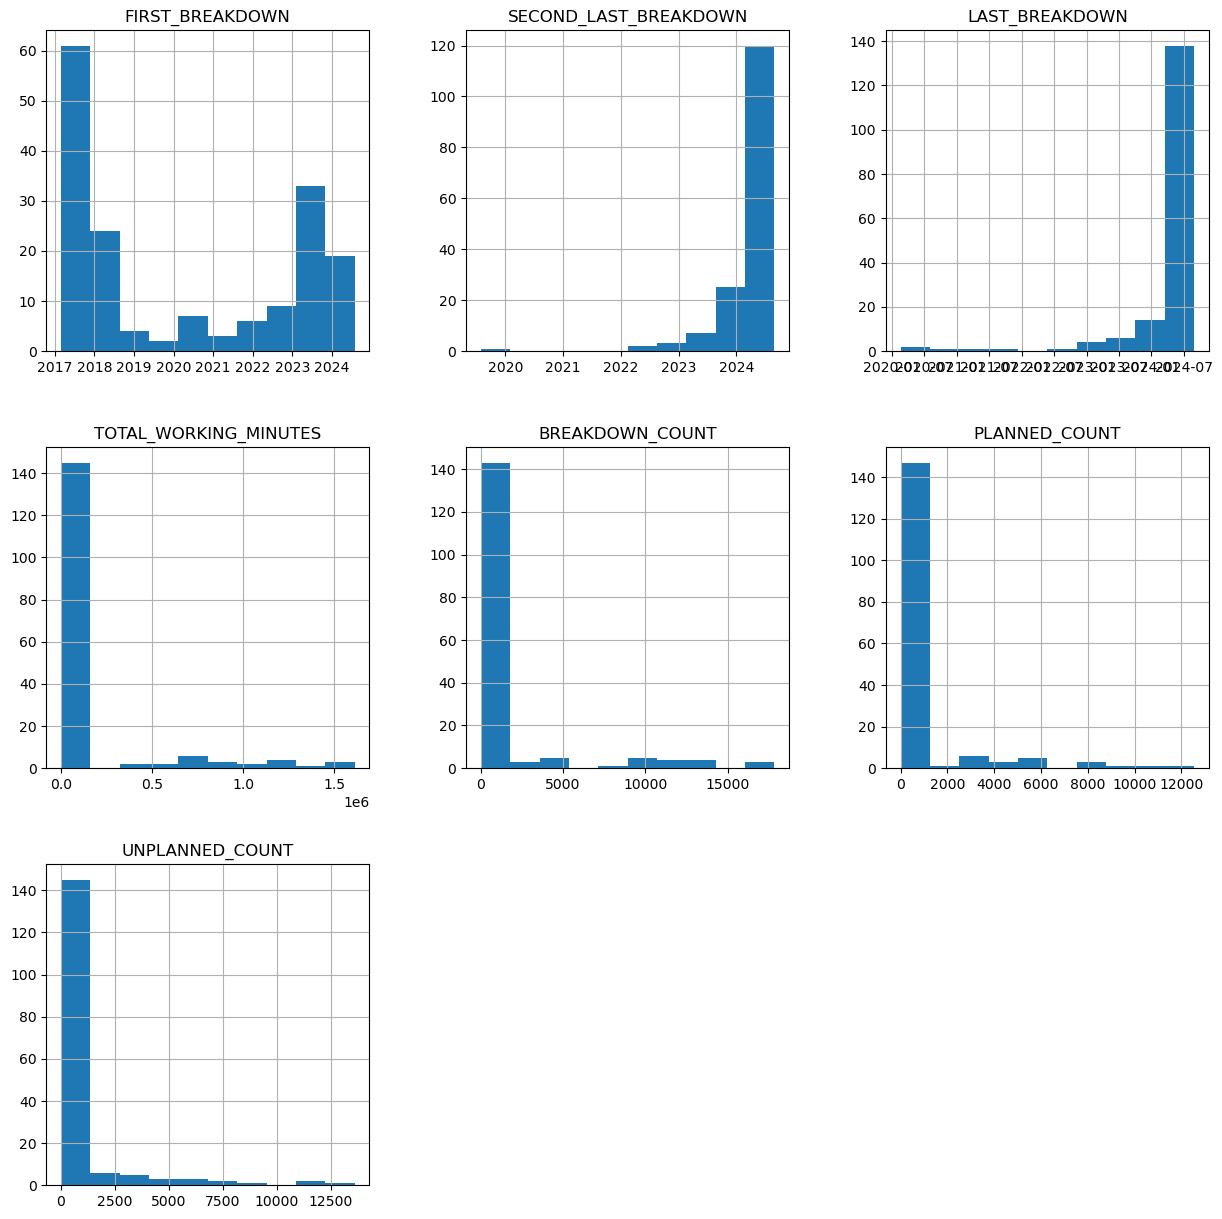

In [13]:
# Histogram of the above 
df_ml.hist(figsize=(15,15))

The histograms reveal the distribution of key maintenance events over time. Most second last and last breakdowns appear recent, suggesting a potential increase in maintenance issues, which may indicate equipment aging or changes in operating conditions. These insights help identify peak maintenance periods, essential for resource planning and understanding when machinery is more likely to fail.

In [14]:
# Describing the 'TARGET' column
df_ml['TARGET'].describe()

count                            158
mean      53 days 17:18:59.240506329
std      129 days 00:54:33.160978956
min                  0 days 00:00:00
25%                  0 days 00:00:00
50%                  7 days 12:00:00
75%                 47 days 18:00:00
max               1252 days 00:00:00
Name: TARGET, dtype: object

In [15]:
# Check for missing values in each column and calculate percentage of nulls
df_ml.isnull().sum() / len(df_ml) * 100

MACHINE_ID                 0.000000
PLANT_ID                   2.976190
LINE_ID                    4.166667
SUBPROCESS_ID             58.333333
FIRST_BREAKDOWN            0.000000
SECOND_LAST_BREAKDOWN      5.952381
LAST_BREAKDOWN             0.000000
FIRST_BREAK_DURATION      54.166667
TOTAL_WORKING_MINUTES      0.000000
BREAKDOWN_COUNT            0.000000
PLANNED_COUNT              0.000000
UNPLANNED_COUNT            0.000000
TOTAL_RUNNUNG_DURATION     5.952381
TARGET                     5.952381
dtype: float64

In [16]:
# Drop rows with missing values in the 'TARGET' column
df_ml_model = df_ml.dropna(subset=['TARGET'])

# Modeling Process <a id = 'mod'></a>

## Regression Models <a id = 'reg'></a>

In [17]:
# Define target variable 'y' as days from 'TARGET'
y = df_ml_model['TARGET'].dt.days.astype(int)
# Use dummy variables for categorical features
X = pd.get_dummies(df_ml_model.drop(columns=['TARGET','MACHINE_ID','LAST_BREAKDOWN','FIRST_BREAK_DURATION', 'BREAKDOWN_COUNT']))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Converting time-based features to days allows for consistent handling of temporal data. The encoding which shows the categorical breakdown of plant locations and line ID will enable us create location-specific maintenance predictions.

In [18]:
# Summary statistics of the target variable 'y'
y.describe()

count     158.000000
mean       53.721519
std       129.037884
min         0.000000
25%         0.000000
50%         7.500000
75%        47.750000
max      1252.000000
Name: TARGET, dtype: float64

<Axes: >

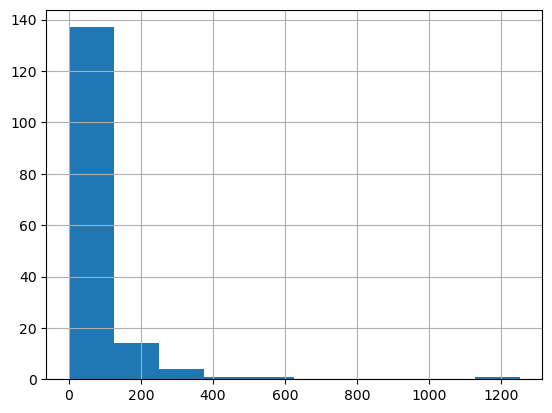

In [19]:
# Histogram for the target variable
y.hist()

In [20]:
# Convert time-based columns to numeric values for model compatibility
for col in X_train.select_dtypes(include=['datetime64','timedelta64']).columns:
  # Extract total seconds for timedelta columns
  if pd.api.types.is_timedelta64_dtype(X_train[col]) and X_train[col].isnull().any() == False:
    X_train[col] = X_train[col].dt.total_seconds().astype(int) / (3600 * 24)
    X_test[col] = X_test[col].dt.total_seconds().astype(int) / (3600 * 24)
  # Extract day of the month for datetime columns
  elif pd.api.types.is_datetime64_dtype(X_train[col]) and X_train[col].isnull().any() == False:
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = pd.to_numeric(X_test[col])

In [21]:
X_train.sample(30)

,FIRST_BREAKDOWN,SECOND_LAST_BREAKDOWN,TOTAL_WORKING_MINUTES,PLANNED_COUNT,UNPLANNED_COUNT,TOTAL_RUNNUNG_DURATION,PLANT_ID_COOLER SERVICE,PLANT_ID_COTA PRODUCTION,PLANT_ID_FLEET,PLANT_ID_MONZA PRODUCTION,PLANT_ID_PRODUCTION,PLANT_ID_SILVERSTONE PRODUCTION,PLANT_ID_SUZUKA PRODUCTION,LINE_ID_ACTIVATED_CARBON,LINE_ID_AIR SYSTEMS,LINE_ID_BOILER ROOM,LINE_ID_CHEMICAL_FEED_SYSTEM,LINE_ID_CHILLING SYSTEMS REFRIG,LINE_ID_CIP SYSTEMS,LINE_ID_CODERS,LINE_ID_COMPRESSOR SYSTEMS REFRIG,LINE_ID_COMPRESSOR_SYSTEMS_REFRIG,LINE_ID_CONDENSING SYSTEMS REFRIG,LINE_ID_CONDENSING_SYSTEMS_REFRIG,LINE_ID_COOLER SERVICE HVAC EXT,LINE_ID_ELECTRICAL SYSTEMS,LINE_ID_ENVIRONMENTAL EXT,LINE_ID_ENVIRONMENTAL INT,LINE_ID_EYE WASH,LINE_ID_FILTRATION,LINE_ID_FILTRATION / CARBON,LINE_ID_FIRE EXTINGUISHERS,LINE_ID_G811 AIR SYSTEMS,LINE_ID_G811 CHEM FEED SYSTEM,LINE_ID_G811 CIP SYSTEMS,LINE_ID_G811 CO2,LINE_ID_G811 ELECTRICAL CONTROLS,LINE_ID_G811 ELECTRICAL EXT,LINE_ID_G811 ELECTRICAL INT,LINE_ID_G811 ENVIRONMENTAL EXT,LINE_ID_G811 ENVIRONMENTAL/CONTRUCTION INT,LINE_ID_G811 EYE WASH,LINE_ID_G811 FILTRATION / CARBON,LINE_ID_G811 HVAC EXT,LINE_ID_G811 HVAC INT,LINE_ID_G811 INSPECTION INT,LINE_ID_G811 INSTRUMENTATION,LINE_ID_G811 LIGHTING EXT,LINE_ID_G811 LIGHTING INT,LINE_ID_G811 LUBE SYSTEMS,LINE_ID_G811 MAIN LUNCH ROOM INT,LINE_ID_G811 MANLIFTS,LINE_ID_G811 MEETINGS/DDS/ADMIN INT,LINE_ID_G811 NATURAL GAS SYSTEM EXT,LINE_ID_G811 PAINTING INT,LINE_ID_G811 PLUMBING EXT,LINE_ID_G811 PLUMBING INT,LINE_ID_G811 RECYCLING,LINE_ID_G811 REFRIGERATION,LINE_ID_G811 RESPIRATORS,LINE_ID_G811 SAFETY EXT,LINE_ID_G811 SAFETY INT,LINE_ID_G811 SECURITY EXT,LINE_ID_G811 SECURITY INT,LINE_ID_G811 SPRINKLERS,LINE_ID_G811 STEAM SYSTEMS,LINE_ID_G811 STORAGE TANKS,LINE_ID_G811 SYRUP BATCHING SYSTEMS,LINE_ID_G811 SYRUP STORAGE,LINE_ID_G811 ULTRAVIOLET SYSTEM,LINE_ID_G811 WATER TREATMENT,LINE_ID_G811 WATER TREATMENT PUMPS,LINE_ID_G812 AIR SYSTEMS,LINE_ID_G812 CHILLING SYSTEMS REFRIG,LINE_ID_G812 CIP SYSTEM,LINE_ID_G812 CO2,LINE_ID_G812 COMPRESSOR SYSTEMS REFRIG,LINE_ID_G812 CONDENSING SYSTEMS REFRIG,LINE_ID_G812 EYE WASH,LINE_ID_G812 HVAC EXT,LINE_ID_G812 PRD FILLER_ROTARY_CAN LINE 1,LINE_ID_G812 PRD FILLER_ROTARY_CAN LINE 3,LINE_ID_G812 PRD FILLER_ROT_BTL_PET LINE 2,LINE_ID_G812 QUALITY ASSURANCE EQUIPMENT,LINE_ID_G812 RECYCLING,LINE_ID_G812 SANITATION,LINE_ID_G812 SPRINKLERS,LINE_ID_G812 STEAM SYSTEMS,LINE_ID_G812 SYRUP BATCHING,LINE_ID_G812 SYRUP STORAGE,LINE_ID_G812 SYRUP/BLENDING ROOM,LINE_ID_G812 WASTE WATER TREATMENT,LINE_ID_G812 WATER TREATMENT,LINE_ID_HEATING SYSTEMS,LINE_ID_HVAC EXT,LINE_ID_HVAC INT,LINE_ID_LIGHTING INT,LINE_ID_LINE #1 - FILLER_ROT_BTL_PET,LINE_ID_LINE #1 - ROT_BTL_PET,LINE_ID_LINE #1-CAN_LINE,LINE_ID_LINE #10-FILLER_ROTARY_CAN,LINE_ID_LINE #2 - BOTTLE_LINE_PET,LINE_ID_LINE #2 - FILLER_ROT_BTL_PET,LINE_ID_LINE #2 - ROT_BTL_PET,LINE_ID_LINE #3 - FILLER_ROT_BTL_PET,LINE_ID_LINE #3-CAN_LINE,LINE_ID_LINE #3-FILLER_ROTARY_CAN,LINE_ID_LINE #4 - BOTTLE_LINE_PET,LINE_ID_LINE #4-FILLER_ROTARY_CAN,LINE_ID_LINE #6-FILLER_ROTARY_BTL_PET,LINE_ID_LINE #8 - FILLER_BIB,LINE_ID_LINE #9 - ROT_BTL_PET,LINE_ID_LINE 1 CAN,LINE_ID_LINE 10,LINE_ID_LINE 2 LARGET PET,LINE_ID_LINE 3 SMALL PET,LINE_ID_MOBILE EQUIPMENT,LINE_ID_NITROGEN SYSTEMS,LINE_ID_PUMPS,LINE_ID_QUALITY ASSURANCE EQUIPMENT,LINE_ID_RECYCLING,LINE_ID_RECYCLING SYSTEM,LINE_ID_SECURITY EXT,LINE_ID_SPRINKLERS,LINE_ID_STORAGE TANKS,LINE_ID_SUGAR/HFC COMPONENTS,LINE_ID_SYRUP AND BLENDING ROOM,LINE_ID_SYRUP BATCHING,LINE_ID_SYRUP BULK INGREDIANTS,LINE_ID_SYRUP/BATCHING/BLENDING ROOM,LINE_ID_SYRUP/BLENDING ROOM,LINE_ID_SYRUP_STORAGE,LINE_ID_SYRYUP BULK INGREDIENTS,LINE_ID_TANK SYSTEMS,LINE_ID_TANKS,LINE_ID_TOWERS,LINE_ID_ULTRAVIOLET SYSTEM,LINE_ID_WAREHOUSE,LINE_ID_WASTE WATER TREATMENT,LINE_ID_WATER SYSTEMS,LINE_ID_WATER TREATMENT,SUBPROCESS_ID_BATCH STATION #2,SUBPROCESS_ID_BOILER,SUBPROCESS_ID_CAPPER,SUBPROCESS_ID_CIP #2 SYSTEM,SUBPROCESS_ID_CIP SYSTEM,SUBPROCESS_ID_CODER,SUBPROCESS_ID_CONVEYOR,SUBPROCESS_ID_DRYER,SUBPROCESS_

In [22]:
# Initialize and train the models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=0.5),
    "Lasso": Lasso(alpha=0.5),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)  # Tune alpha and l1_ratio
}

results = {}
# Fit each model and calculate performance metrics
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_trian = math.sqrt(mse_train)
    rmse_test = math.sqrt(mse_test)

    results[model_name] = {"train MSE": mse_train, "test MSE": mse_test,
                           "train R-squared": r2_train, "test R-squared": r2_test,
                           "train RMSE": rmse_trian, "test RMSE": rmse_test}

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  train MSE: {metrics['train MSE']:.4f}")
    print(f"  test MSE: {metrics['test MSE']:.4f}")
    print(f"  train RMSE: {metrics['train RMSE']:.4f}")
    print(f"  test RMSE: {metrics['test RMSE']:.4f}")
    print(f"  train R-squared: {metrics['train R-squared']:.4f}")
    print(f"  test R-squared: {metrics['test R-squared']:.4f}")

OLS:
  train MSE: 3946.4932
  test MSE: 6998.6032
  train RMSE: 62.8211
  test RMSE: 83.6577
  train R-squared: 0.7536
  test R-squared: 0.6086
Ridge:
  train MSE: 3974.6909
  test MSE: 6934.8299
  train RMSE: 63.0451
  test RMSE: 83.2756
  train R-squared: 0.7519
  test R-squared: 0.6122
Lasso:
  train MSE: 1032.0511
  test MSE: 7464.0931
  train RMSE: 32.1256
  test RMSE: 86.3950
  train R-squared: 0.9356
  test R-squared: 0.5826
ElasticNet:
  train MSE: 3785.0880
  test MSE: 6767.9204
  train RMSE: 61.5231
  test RMSE: 82.2674
  train R-squared: 0.7637
  test R-squared: 0.6215


In [23]:
results

{'OLS': {'train MSE': 3946.493206992962,
  'test MSE': 6998.603180316421,
  'train R-squared': 0.7536380726185445,
  'test R-squared': 0.60858948048813,
  'train RMSE': 62.8211207078715,
  'test RMSE': 83.65765464269495},
 'Ridge': {'train MSE': 3974.6908869116955,
  'test MSE': 6934.829858653968,
  'train R-squared': 0.751877817524185,
  'test R-squared': 0.6121561277632752,
  'train RMSE': 63.045149590683785,
  'test RMSE': 83.27562583766013},
 'Lasso': {'train MSE': 1032.0510604171961,
  'test MSE': 7464.093134024629,
  'train R-squared': 0.9355736662741686,
  'test R-squared': 0.582556047828179,
  'train RMSE': 32.12555151926883,
  'test RMSE': 86.39498326884859},
 'ElasticNet': {'train MSE': 3785.0880316644802,
  'test MSE': 6767.9204142064555,
  'train R-squared': 0.7637138761224773,
  'test R-squared': 0.6214908636640589,
  'train RMSE': 61.52306910147185,
  'test RMSE': 82.2673715041781}}

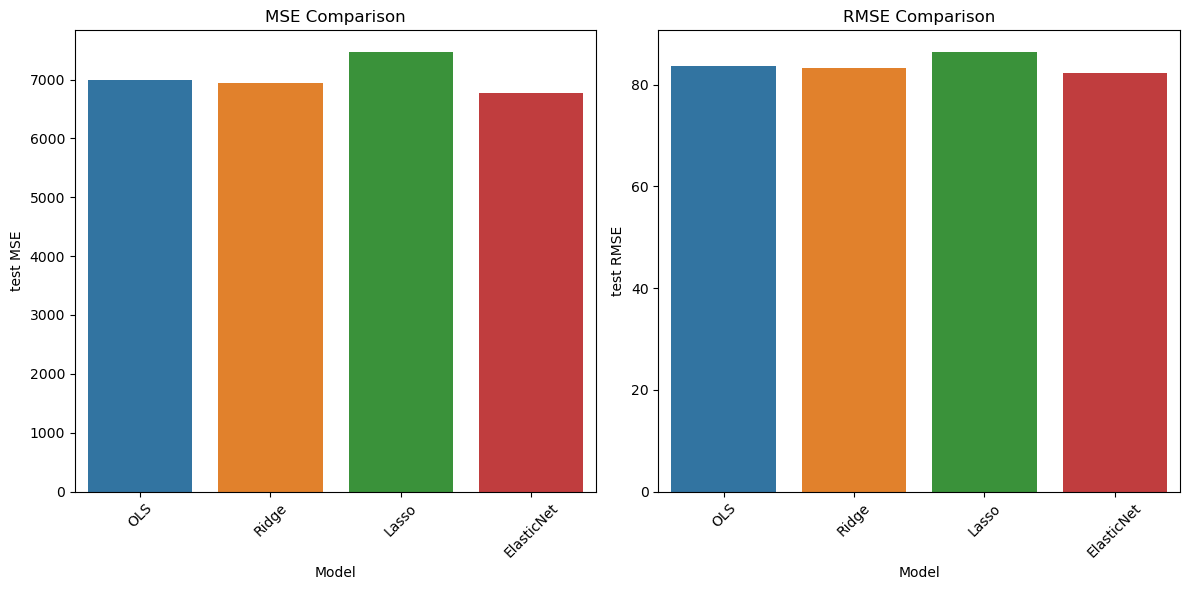

OLS:
  RMSE: 83.6577
  MSE: 6998.6032
  R-squared: 0.6086
Ridge:
  RMSE: 83.2756
  MSE: 6934.8299
  R-squared: 0.6122
Lasso:
  RMSE: 86.3950
  MSE: 7464.0931
  R-squared: 0.5826
ElasticNet:
  RMSE: 82.2674
  MSE: 6767.9204
  R-squared: 0.6215


In [24]:
# Create dataframes for visualization
mse_df = pd.DataFrame(results).T.reset_index()
mse_df = mse_df.rename(columns={'index': 'Model'})


plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='test MSE', data=mse_df)
plt.title('MSE Comparison')
plt.xticks(rotation=45)

# Plot RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='test RMSE', data=mse_df)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print RMSE values
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['test RMSE']:.4f}")
    print(f"  MSE: {metrics['test MSE']:.4f}")
    print(f"  R-squared: {metrics['test R-squared']:.4f}")

The model comparison provides valuable insights into performance across different regression approaches. The ElasticNet model stands out, achieving the lowest test RMSE (82.27) and MSE (6767.92), suggesting it strikes the best balance between bias and variance, making it highly suitable for predicting maintenance outcomes. Both Ridge and OLS models show comparable performance, with RMSE values close to ElasticNet's, but slightly lower R-squared scores, indicating a less precise fit to the data. In contrast, the Lasso model, while demonstrating low training MSE, exhibits higher test RMSE and MSE, which may indicate overfitting. Overall, ElasticNet appears to be the most effective model for this maintenance forecasting task, enabling Swire Coca-Cola to better predict equipment breakdowns and plan accordingly.

In [25]:
# Create the summary tables for OLS, LASSO, RIDGE, and ELASTICNET Regression models in results
results_df = pd.DataFrame(results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})
results_df

,Model,train MSE,test MSE,train R-squared,test R-squared,train RMSE,test RMSE
0,OLS,3946.493207,6998.603180,0.753638,0.608589,62.821121,83.657655
1,Ridge,3974.690887,6934.829859,0.751878,0.612156,63.045150,83.275626
2,Lasso,1032.051060,7464.093134,0.935574,0.582556,32.125552,86.394983
3,ElasticNet,3785.088032,6767.920414,0.763714,0.621491,61.523069,82.267372


ElasticNet appears to be the most effective model for this dataset, achieving a test RMSE of 82.27 and a test R-squared of 0.6215, indicating strong predictive accuracy. This finding is valid because ElasticNet balances both L1 and L2 regularization, which helps manage the variance and bias trade-off effectively. By incorporating both regularization techniques, ElasticNet reduces overfitting without overly constraining the model's flexibility, resulting in improved generalization performance compared to OLS, Ridge, and Lasso.

### Cross validation

In [45]:
# Initialize models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=0.5),
    "Lasso": Lasso(alpha=0.5),
    "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5)
}

results = {}

# Cross-validation loop
for model_name, model in models.items():
    # Perform cross-validation
    cv_results = cross_validate(
        model, X_train, y_train, 
        scoring=['neg_mean_squared_error'], 
        cv=5,  # Number of folds for cross-validation
        return_train_score=True
    )
    
    # Calculate performance metrics
    mse_train_cv = -cv_results['train_neg_mean_squared_error'].mean()  # Convert neg_mean_squared_error to positive MSE
    mse_test_cv = -cv_results['test_neg_mean_squared_error'].mean()    # Convert neg_mean_squared_error to positive MSE
    rmse_train_cv = np.sqrt(mse_train_cv)
    rmse_test_cv = np.sqrt(mse_test_cv)

    # Store the results
    results[model_name] = {
        "train MSE": mse_train_cv, "test MSE": mse_test_cv,
        "train RMSE": rmse_train_cv, "test RMSE": rmse_test_cv
    }

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  train MSE (CV): {metrics['train MSE']:.4f}")
    print(f"  test MSE (CV): {metrics['test MSE']:.4f}")
    print(f"  train RMSE (CV): {metrics['train RMSE']:.4f}")
    print(f"  test RMSE (CV): {metrics['test RMSE']:.4f}")

OLS:
  train MSE (CV): 3753.2505
  test MSE (CV): 6571.0179
  train RMSE (CV): 61.2638
  test RMSE (CV): 81.0618
Ridge:
  train MSE (CV): 3916.0899
  test MSE (CV): 6344.0796
  train RMSE (CV): 62.5787
  test RMSE (CV): 79.6497
Lasso:
  train MSE (CV): 801.4603
  test MSE (CV): 6952.7886
  train RMSE (CV): 28.3101
  test RMSE (CV): 83.3834
ElasticNet:
  train MSE (CV): 3568.4541
  test MSE (CV): 6504.6471
  train RMSE (CV): 59.7365
  test RMSE (CV): 80.6514


After cross validation, The ElasticNet model once again performs robustly, achieving a relatively low test RMSE of 80.65, indicating good predictive power. Ridge regression also shows strong generalization with a test RMSE of 79.65, slightly outperforming ElasticNet on this metric but at a higher training error, suggesting ElasticNet balances bias and variance better. OLS, while slightly higher in test RMSE (81.06), remains a viable model with minimal overfitting, as seen in the close alignment between train and test errors. Lasso shows the lowest training RMSE (28.31) but the highest test RMSE (83.38), indicating it overfits the training data and generalizes poorly to new data. Overall, ElasticNet and Ridge emerge as reliable options, with ElasticNet’s performance demonstrating it may be particularly well-suited to manage the complex feature interactions in this dataset.

In [26]:
# Get each model's variable, intercept, coefficient, t-score, and p-value in model results
import statsmodels.api as sm

# Add a constant column to X_train for the intercept
X_train_with_constant = X_train.astype(float)
# Fit the model using statsmodels
model_statsmodels = sm.OLS(y_train, X_train_with_constant).fit()
model_statsmodels.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.075
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.130
Time:                        22:13:36   Log-Likelihood:                -786.63
No. Observations:                 126   AIC:                             1579.
Df Residuals:                     123   BIC:                             1588.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
FIRST_BREAKDOWN                               2.042e-16   1.39e-16      1.465      0.146   -7.17e-17     4.8e-16
SECOND_LAST_BREAKDOWN                        -1.587e-16    1.3e-16     -1.219      0.225   -4.17e-16    9.91e-17
TOTAL_WORKING_MINUTES                        -3.074e-05    3.3e-05     -0.932      0.353    -9.6e-05    3.45e-05
PLANNED_COUNT                                 -1.35e-07   1.45e-07     -0.932      0.353   -4.22e-07    1.52e-07
UNPLANNED_COUNT                              -1.914e-07   2.05e-07     -0.932      0.353   -5.98e-07    2.15e-07
TOTAL_RUNNUNG_DURATION                        9.407e-24   1.01e-23      0.932      0.353   -1.06e-23    2.94e-23
PLANT_ID_COOLER SERVICE                       4.827e-13   5.18e-13      0.932      0.353   -5.43e-13    1.51e-12
PLANT_ID_COTA PRODUCTION                     -3.592e-12   3.85e-12     -0.932      0.353   -1.12e-11    4.04e-12
PLANT_ID_FLEET                                9.219e-14   9.89e-14      0.932      0.353   -1.04e-13    2.88e-13
PLANT_ID_MONZA PRODUCTION                     9.598e-13   1.03e-12      0.932      0.353   -1.08e-12       3e-12
PLANT_ID_PRODUCTION                           5.355e-12   5.75e-12      0.932      0.353   -6.02e-12    1.67e-11
PLANT_ID_SILVERSTONE PRODUCTION              -4.848e-12    5.2e-12     -0.932      0.353   -1.51e-11    5.45e-12
PLANT_ID_SUZUKA PRODUCTION                    3.687e-13   3.96e-13      0.932      0.353   -4.14e-13    1.15e-12
LINE_ID_ACTIVATED_CARBON                      6.678e-13   7.17e-13      0.932      0.353   -7.51e-13    2.09e-12
LINE_ID_AIR SYSTEMS                                   0          0        nan        nan           0           0
LINE_ID_BOILER ROOM                          -1.071e-13   1.15e-13     -0.932      0.353   -3.35e-13     1.2e-13
LINE_ID_CHEMICAL_FEED_SYSTEM                          0          0        nan        nan           0           0
LINE_ID_CHILLING SYSTEMS REFRIG                6.19e-13   6.64e-13      0.932      0.353   -6.96e-13    1.93e-12
LINE_ID_CIP SYSTEMS                          -6.423e-15   6.89e-15     -0.932      0.353   -2.01e-14    7.22e-15
LINE_ID_CODERS                                        0          0        nan        nan           0           0
LINE_ID_COMPRESSOR SYSTEMS REFRIG             6.628e-13   7.11e-13      0.932      0.353   -7.45e-13    2.07e-12
LINE_ID_COMPRESSOR_SYSTEMS_REFRIG             6.602e-13   7.08e-13      0.932      0.353   -7.42e-13    2.06e-12
LINE_ID_CONDENSING SYSTEMS REFRIG             1.297e-12   1.39e-12      0.932      0.353   -1.46e-12    4.05e-12
LINE_ID_CONDENSING_SYSTEMS_REFRIG             6.517e-13   6.99e-13      0.932      0.353   -7.33e-13    2.04e-12
LINE_ID_COOLER SERVICE HVAC EXT 

The OLS regression results indicate limited predictive power, with an R-squared of 0.033, showing that only 3.3% of the target's variance is explained. High p-values for most coefficients suggest weak relationships between predictors and the target. Additionally, the large condition number (1e+16) points to multicollinearity, which can destabilize estimates. Diagnostic tests show non-normal residuals with high skewness and kurtosis, further undermining model assumptions. Using regularization techniques, like Ridge or Lasso, may help address multicollinearity and improve model stability.

### Hyperparameter Tuning <a id = 'hyper'></a>

In [46]:
# Define the parameter grid for ElasticNet
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],  # Try different values for alpha
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]  # Try different values for l1_ratio
}

# Initialize ElasticNet
elasticnet = ElasticNet()

# Use GridSearchCV to find the best combination of alpha and l1_ratio
grid_search = GridSearchCV(estimator=elasticnet, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Train the ElasticNet model with the best parameters
best_model = grid_search.best_estimator_

# Predict on train and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Calculate performance metrics
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = math.sqrt(mse_train)
rmse_test = math.sqrt(mse_test)

# Print the results
print(f"ElasticNet (Best Model) with alpha={best_params['alpha']} and l1_ratio={best_params['l1_ratio']}:")
print(f"  train MSE: {mse_train:.4f}")
print(f"  test MSE: {mse_test:.4f}")
print(f"  train RMSE: {rmse_train:.4f}")
print(f"  test RMSE: {rmse_test:.4f}")
print(f"  train R-squared: {r2_train:.4f}")
print(f"  test R-squared: {r2_test:.4f}")

ElasticNet (Best Model) with alpha=1.0 and l1_ratio=1.0:
  train MSE: 1969.2611
  test MSE: 6959.2297
  train RMSE: 44.3764
  test RMSE: 83.4220
  train R-squared: 0.8771
  test R-squared: 0.6108


The optimized ElasticNet model, with hyperparameters alpha=1.0 and l1_ratio=1.0, shows a good fit on the training data (R-squared = 0.8771), explaining approximately 87.7% of the variance. However, the model's performance drops on the test data, with an R-squared of 0.6108, indicating that it explains about 61% of the variability in unseen data. The relatively high RMSE on the test set (83.4220) suggests that there is room for improvement in the model's generalization, possibly due to overfitting or the need for further tuning or feature refinement.<br>In predicting maintenance issues at the Swire Coca-Cola plant, the ElasticNet model’s performance suggests it can capture key factors related to breakdowns but may struggle with accurately forecasting all instances due to some variance loss on test data. This indicates potential for improvement, perhaps by refining features or addressing specific plant conditions to enhance predictive reliability.

## Survival Analysis <a id = 'survive'></a>

In [27]:
# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")

# Filter for unplanned maintenance only
df_unplanned = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

In [28]:
df_unplanned.isnull().sum() / len(df) * 100

ORDER_ID                            0.000000
PLANT_ID                            0.000000
PRODUCTION_LOCATION                 0.000000
EXECUTION_START_DATE                0.000000
EXECUTION_FINISH_DATE               0.000000
ACTUAL_START_TIME                   0.000000
ACTUAL_FINISH_TIME                  0.000000
ACTUAL_WORK_IN_MINUTES              0.000000
MAINTENANCE_PLAN                   89.308635
MAINTENANCE_ITEM                   89.308635
MAINTENANCE_ACTIVITY_TYPE           0.000000
ORDER_DESCRIPTION                  79.557391
MAINTENANCE_TYPE_DESCRIPTION       79.555639
FUNCTIONAL_LOC                     79.556060
FUNCTIONAL_AREA_NODE_1_MODIFIED    79.595226
FUNCTIONAL_AREA_NODE_2_MODIFIED    79.997253
FUNCTIONAL_AREA_NODE_3_MODIFIED    80.600155
FUNCTIONAL_AREA_NODE_4_MODIFIED    80.935412
FUNCTIONAL_AREA_NODE_5_MODIFIED    89.345209
EQUIPMENT_ID                       79.555639
EQUIPMENT_DESC                     87.748658
EQUIP_CAT_DESC                     87.748658
EQUIP_STAR

The data quality assessment reveals significant gaps in key maintenance-related fields, with over 79% missing values in columns like `ORDER_DESCRIPTION`, `MAINTENANCE_TYPE_DESCRIPTION`, and `FUNCTIONAL_LOC`. Such high levels of missing data could hinder the precision of predictive models, particularly in understanding maintenance patterns and equipment-specific issues. Addressing these gaps—either by imputing missing values or focusing on alternative data fields,will be essential to improve the robustness of predictive maintenance insights for Swire Coca-Cola.

### Kaplan Meier Curve

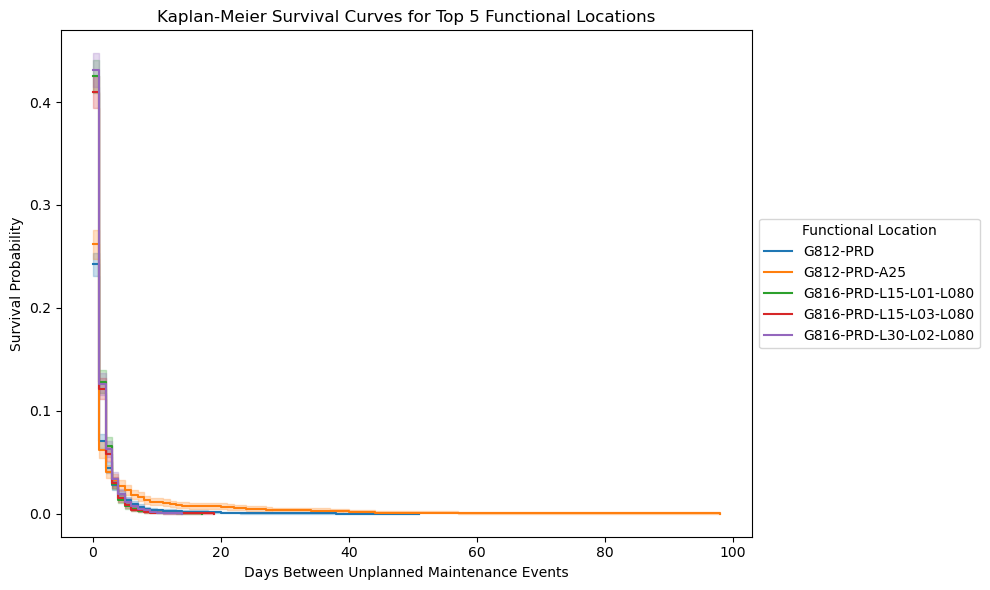

In [29]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")  # Replace with your file path

# Filter for unplanned maintenance only
df_unplanned = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Assume df_unplanned is the filtered DataFrame for unplanned maintenance
df_unplanned['EXECUTION_START_DATE'] = pd.to_datetime(df_unplanned['EXECUTION_START_DATE'])
df_unplanned['EXECUTION_FINISH_DATE'] = pd.to_datetime(df_unplanned['EXECUTION_FINISH_DATE'])

# Sort data by FUNCTIONAL_LOC and EXECUTION_START_DATE
df_unplanned = df_unplanned.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'])

# Calculate time-to-event as time since the last unplanned maintenance for each FUNCTIONAL_LOC
df_unplanned['time_to_event'] = df_unplanned.groupby('FUNCTIONAL_LOC')['EXECUTION_START_DATE'].diff().dt.days

# Drop rows where time_to_event is NaN (first occurrence for each FUNCTIONAL_LOC)
df_unplanned = df_unplanned.dropna(subset=['time_to_event'])

# Create an event column (1 indicates an unplanned maintenance event occurred)
df_unplanned['event_occurred'] = 1

# Count the frequency of unplanned maintenance events for each FUNCTIONAL_LOC
top_5_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 locations
df_top_5 = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_5_locations)]

# Initialize Kaplan-Meier model
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top 10 locations
plt.figure(figsize=(10, 6))

for location, group in df_top_5.groupby('FUNCTIONAL_LOC'):
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves for Top 5 Functional Locations")
plt.xlabel("Days Between Unplanned Maintenance Events")
plt.ylabel("Survival Probability")
plt.legend(title="Functional Location", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves for the top five functional locations indicate that most unplanned maintenance events occur within a short timeframe following the previous breakdown, as shown by the steep initial drop in survival probability. This suggests that equipment at these locations is prone to recurrent issues soon after repairs, implying potentially inadequate maintenance practices or underlying design flaws. Addressing these frequent failures through preventive maintenance or targeted interventions could help prolong operational periods and reduce the likelihood of rapid repeat breakdowns.








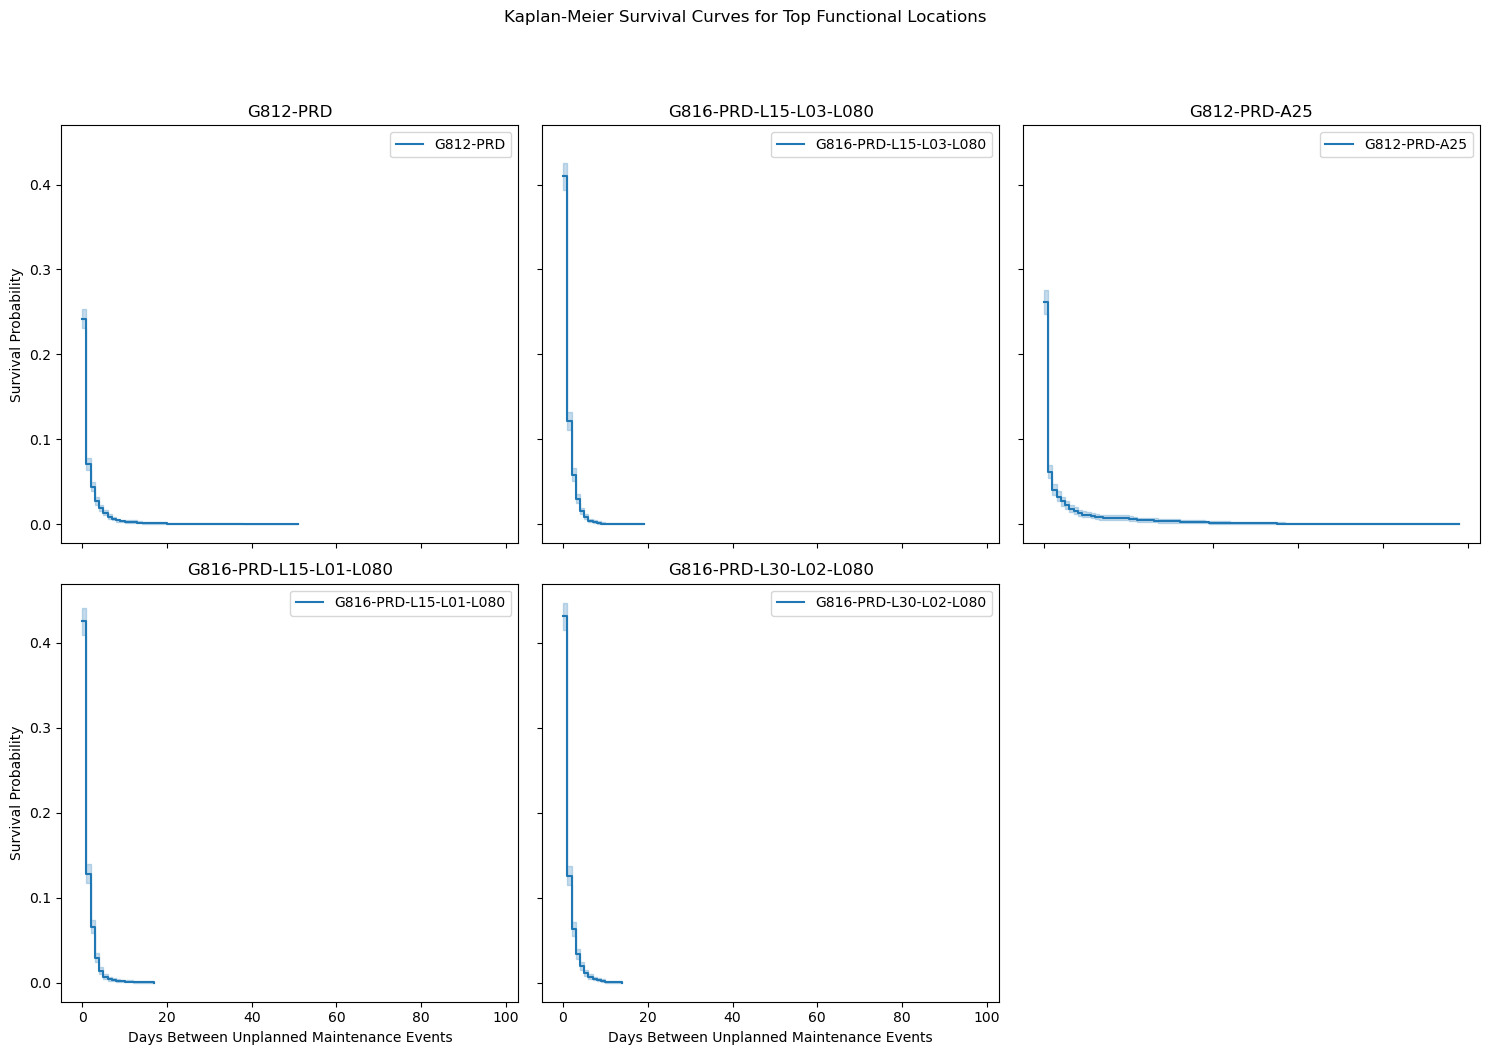

In [30]:
# Count the frequency of unplanned maintenance events for each FUNCTIONAL_LOC
top_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(5).index

# Filter the dataset to include only the top 5 locations
df_top_locations = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_locations)]

# Initialize Kaplan-Meier model
kmf = KaplanMeierFitter()

# Set up facet wraps
num_locations = len(top_locations)
cols = 3  # Number of columns in the facet grid
rows = math.ceil(num_locations / cols)  # Calculate rows based on the number of columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, location in enumerate(top_locations):
    ax = axes[i]
    group = df_top_locations[df_top_locations['FUNCTIONAL_LOC'] == location]
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function(ax=ax)
    ax.set_title(location)
    ax.set_xlabel("Days Between Unplanned Maintenance Events")
    ax.set_ylabel("Survival Probability")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Kaplan-Meier Survival Curves for Top Functional Locations", y=1.05)
plt.tight_layout()
plt.show()


The Kaplan-Meier survival curves reveal varying survival rates across the top functional locations, with some locations experiencing faster declines in survival probability than others. This variation suggests that certain areas or equipment within the plant may be under more operational stress or have components that are more prone to failure. Additionally, the rapid decrease in survival probability within the first few days highlights the urgency for targeted interventions at these locations to prevent recurrent issues and extend equipment uptime.<br>
1. **G812-PRD**: This location shows a steep decline in survival probability within the first few days, suggesting frequent unplanned maintenance and potentially high wear or operational stress.

2. **G816-PRD-L15-L03-L080**: The survival curve drops sharply early on, indicating recurrent breakdowns that may benefit from more robust preventative maintenance strategies.

3. **G812-PRD-A25**: This functional location also exhibits a quick decrease in survival probability, hinting at possible issues with specific components or operational practices.

4. **G816-PRD-L15-L01-L080**: The survival probability here reduces rapidly, suggesting that this location may experience significant strain, possibly due to high usage or challenging operational conditions.

5. **G816-PRD-L30-L02-L080**: Similar to other locations, this area sees a swift drop in survival, pointing to the need for a targeted maintenance approach to address frequent failures.

### Log Rank Test for Kaplan-Meier curve

In [31]:
from lifelines.statistics import logrank_test
# Perform pairwise log-rank tests between all top locations
print("Log-rank test results between top functional locations:\n")
for i, loc1 in enumerate(top_locations):
    for j, loc2 in enumerate(top_locations):
        if j <= i:
            continue  # Avoid redundant comparisons
        group1 = df_top_locations[df_top_locations['FUNCTIONAL_LOC'] == loc1]
        group2 = df_top_locations[df_top_locations['FUNCTIONAL_LOC'] == loc2]
        results = logrank_test(
            group1['time_to_event'], group2['time_to_event'],
            event_observed_A=group1['event_occurred'],
            event_observed_B=group2['event_occurred']
        )
        print(f"{loc1} vs {loc2}: p-value = {results.p_value:.4f}")

Log-rank test results between top functional locations:

G812-PRD vs G816-PRD-L15-L03-L080: p-value = 0.0000
G812-PRD vs G812-PRD-A25: p-value = 0.0054
G812-PRD vs G816-PRD-L15-L01-L080: p-value = 0.0000
G812-PRD vs G816-PRD-L30-L02-L080: p-value = 0.0000
G816-PRD-L15-L03-L080 vs G812-PRD-A25: p-value = 0.0000
G816-PRD-L15-L03-L080 vs G816-PRD-L15-L01-L080: p-value = 0.2433
G816-PRD-L15-L03-L080 vs G816-PRD-L30-L02-L080: p-value = 0.0756
G812-PRD-A25 vs G816-PRD-L15-L01-L080: p-value = 0.0000
G812-PRD-A25 vs G816-PRD-L30-L02-L080: p-value = 0.0000
G816-PRD-L15-L01-L080 vs G816-PRD-L30-L02-L080: p-value = 0.5792


The log-rank test results reveal statistically significant differences in the survival times between several functional locations (e.g., G812-PRD vs. G816-PRD-L15-L03-L080, p < 0.0001), suggesting that maintenance patterns differ markedly across locations. Functional locations such as G816-PRD-L15-L03-L080 and G816-PRD-L30-L02-L080, with higher p-values in pairwise comparisons, exhibit more similar maintenance intervals, potentially indicating comparable wear and operational conditions. These insights can help prioritize targeted interventions at locations with more rapid survival declines to enhance equipment longevity and operational efficiency.<br>The significant differences in survival times between functional locations suggest that maintenance needs vary across the Swire plant, indicating that a location-specific predictive maintenance approach could enhance efficiency and reduce unexpected breakdowns.

In [32]:
# Additional Analysis: Summary statistics for time-to-event, sorted by mean
top_locations = df_unplanned['FUNCTIONAL_LOC'].value_counts().nlargest(10).index
# Filter the dataset to include only the top 10 locations
df_top_locations = df_unplanned[df_unplanned['FUNCTIONAL_LOC'].isin(top_locations)]
survival_summary = df_top_locations.groupby('FUNCTIONAL_LOC')['time_to_event'].describe().sort_values(by='mean')
print("\nSurvival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Replacements):")
print(survival_summary)


Survival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Replacements):
                        count      mean       std  min  25%  50%  75%   max
FUNCTIONAL_LOC                                                             
G812-PRD               5406.0  0.473918  1.617539  0.0  0.0  0.0  0.0  51.0
G816-PRD-L15-L03-L080  3800.0  0.656579  1.149846  0.0  0.0  0.0  1.0  19.0
G816-PRD-L15-L01-L080  3639.0  0.685078  1.167064  0.0  0.0  0.0  1.0  17.0
G812-PRD-A25           3641.0  0.702005  3.541655  0.0  0.0  0.0  1.0  98.0
G816-PRD-L30-L02-L080  3554.0  0.702026  1.204813  0.0  0.0  0.0  1.0  14.0
G816-PRD-L30-L02-L100  2474.0  1.006063  1.776300  0.0  0.0  0.0  1.0  18.0
G816-PRD-L15-L01-L120  2353.0  1.061198  1.899605  0.0  0.0  0.0  1.0  19.0
G816-PRD-L15-L03-L120  2190.0  1.131050  2.102381  0.0  0.0  0.0  1.0  34.0
G816-PRD-L30-L02-L030  2028.0  1.228797  1.853521  0.0  0.0  1.0  2.0  27.0
G221-PRD-L30-L02-L080  2144.0  1.248134  2.200411  0.0  0.0

The summary statistics reveal that certain functional locations, like "G812-PRD," have extremely low mean times between unplanned maintenance events, with an average of only 0.47 days, indicating frequent breakdowns. Locations such as "G221-PRD-L30-L02-L080" and "G816-PRD-L30-L02-L030" show higher mean times between events, around 1.2 days, suggesting comparatively better performance or lower maintenance needs. These variations highlight potential areas where targeted maintenance strategies could reduce disruptions, particularly for locations with higher frequencies of breakdowns.

### Identifying Frequently Mentioned Parts in Order Descriptions

In [35]:
# Sample list of common parts (you can expand this based on actual descriptions)
common_parts = ['filler','conveyor', 'valve', 'pump', 'filter', 'motor', 'bearing', 'compressor', 'seal', 'belt', 'chain', 'bottle', 'pallet']

# Function to extract part keywords from a description
def extract_parts(description, keywords):
    found_parts = []
    for part in keywords:
        if re.search(r'\b' + re.escape(part) + r'\b', description):
            found_parts.append(part)
    return found_parts

# Apply extraction function to ORDER_DESCRIPTION
df_unplanned['ORDER_DESCRIPTION'] = df_unplanned['ORDER_DESCRIPTION'].fillna("").str.lower()
df_unplanned['replaced_parts'] = df_unplanned['ORDER_DESCRIPTION'].apply(lambda x: extract_parts(x, common_parts))

# Flatten list of parts and count occurrences
all_parts = [part for sublist in df_unplanned['replaced_parts'] for part in sublist]
part_counts = Counter(all_parts)

# Create summary DataFrame
part_summary_df = pd.DataFrame(part_counts.items(), columns=['Part', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display the summary table
print(part_summary_df)

          Part  Frequency
0       filler       8196
9        valve       5229
3     conveyor       4960
8         belt       3776
7        chain       3087
11      pallet       2543
2       bottle       2327
6        motor       2090
4         pump       1739
5       filter       1077
12     bearing        740
10        seal        478
1   compressor        378


The part summary reveals the most frequently replaced components across the unplanned maintenance events, providing insights into potential maintenance focus areas for Swire Coca-Cola's production lines. Components like "filler" (8,196 replacements) and "valve" (5,229 replacements) are among the most commonly replaced, indicating they may be prone to frequent breakdowns or wear. This pattern highlights specific parts that might benefit from predictive maintenance initiatives or inventory stocking adjustments to reduce downtime. On the other hand, less frequently replaced parts, like "compressor" (378 replacements), may not require as frequent intervention, allowing resources to be allocated efficiently.

### Survival Analysis of Unplanned Filler Replacements Across Functional Locations

Top 10 Functional Locations with Most Unplanned Filler Replacements:
     Functional Location  Filler Replacement Count
0  G816-PRD-L15-L01-L080                       767
1  G221-PRD-L15-L04-L080                       723
2  G816-PRD-L15-L03-L080                       716
3  G816-PRD-L30-L02-L080                       683
4  G221-PRD-L30-L02-L080                       672
5  G291-PRD-L30-L02-L080                       496
6  G291-PRD-L30-L01-L080                       409
7  G812-PRD-L15-L01-L080                       278
8  G291-PRD-L30-L03-L080                       260
9  G261-PRD-L30-L01-L080                       259


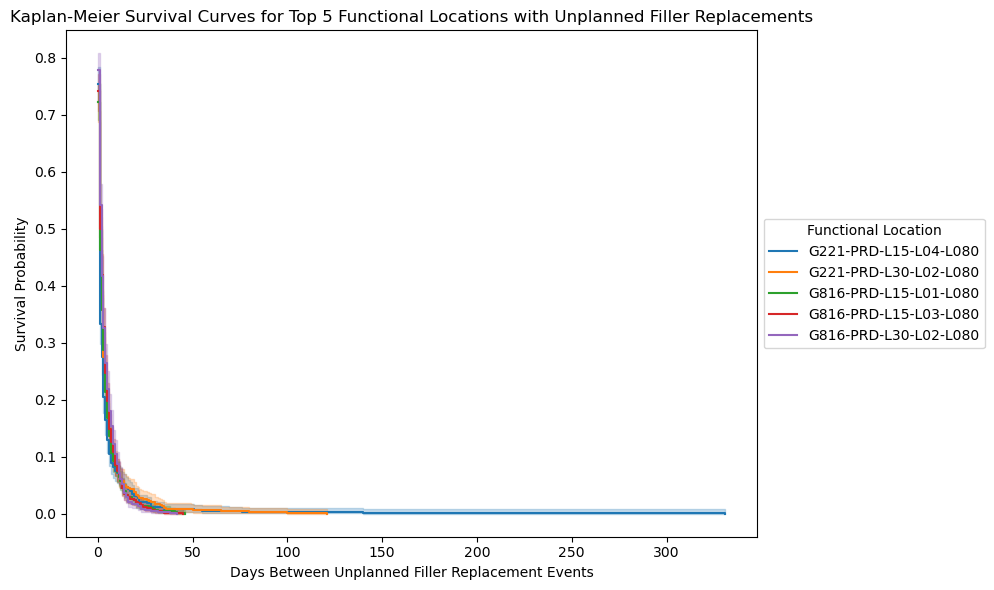


Survival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Unplanned Replacements):
                       count      mean        std  min  25%  50%   75%    max
FUNCTIONAL_LOC                                                               
G816-PRD-L15-L01-L080  766.0  3.253264   5.351057  0.0  0.0  1.0   4.0   46.0
G816-PRD-L15-L03-L080  715.0  3.488112   5.158639  0.0  0.0  1.0   4.0   45.0
G816-PRD-L30-L02-L080  682.0  3.645161   4.977206  0.0  1.0  2.0   5.0   42.0
G221-PRD-L15-L04-L080  722.0  3.681440  14.785603  0.0  1.0  1.0   3.0  331.0
G221-PRD-L30-L02-L080  671.0  3.934426   9.139313  0.0  0.0  1.0   4.0  121.0
G291-PRD-L30-L02-L080  495.0  5.284848   6.963008  0.0  1.0  4.0   7.0   69.0
G291-PRD-L30-L01-L080  408.0  6.659314   8.128218  0.0  2.0  5.0   8.0   92.0
G812-PRD-L15-L01-L080  277.0  9.227437  11.959877  0.0  1.0  4.0  12.0   78.0
G291-PRD-L30-L03-L080  259.0  9.691120  33.550107  0.0  1.0  2.0   6.0  422.0
G261-PRD-L30-L01-L080  258.

In [36]:
# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")  # Replace with your actual file path

# Step 1: Filter for Unplanned Filler Replacement Orders
# Assuming 'MAINTENANCE_TYPE_DESCRIPTION' indicates if it's 'Unplanned' or 'Planned'
df_unplanned_filler = df[ 
    (df['ORDER_DESCRIPTION'].str.contains('filler', case=False, na=False)) &
    (df['MAINTENANCE_ACTIVITY_TYPE'].str.contains('unplanned', case=False, na=False))
]

# Step 2: Count Filler Replacements by Functional Location for Unplanned Instances
filler_replacement_counts = df_unplanned_filler['FUNCTIONAL_LOC'].value_counts()

# Step 3: Get the top 10 functional locations with the most unplanned filler replacements
top_10_filler_locations = filler_replacement_counts.head(10)
top_10_filler_locations_df = top_10_filler_locations.reset_index()
top_10_filler_locations_df.columns = ['Functional Location', 'Filler Replacement Count']

# Display the top 10 functional locations with most unplanned filler replacements
print("Top 10 Functional Locations with Most Unplanned Filler Replacements:")
print(top_10_filler_locations_df)

# Step 4: Filter the unplanned filler dataset for only the top 10 functional locations
df_top_filler = df_unplanned_filler[df_unplanned_filler['FUNCTIONAL_LOC'].isin(top_10_filler_locations.index)]

# Step 5: Prepare data for survival analysis
# Convert EXECUTION_START_DATE to datetime
df_top_filler['EXECUTION_START_DATE'] = pd.to_datetime(df_top_filler['EXECUTION_START_DATE'])
df_top_filler = df_top_filler.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'])

# Calculate time-to-event as the time since the last unplanned filler replacement for each FUNCTIONAL_LOC
df_top_filler['time_to_event'] = df_top_filler.groupby('FUNCTIONAL_LOC')['EXECUTION_START_DATE'].diff().dt.days

# Drop rows where time_to_event is NaN (first occurrence for each FUNCTIONAL_LOC)
df_top_filler = df_top_filler.dropna(subset=['time_to_event'])

# Create an event column (1 indicates a filler replacement event occurred)
df_top_filler['event_occurred'] = 1

# Step 6: Perform Kaplan-Meier Survival Analysis for Top 5 Functional Locations
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top 5 functional locations
plt.figure(figsize=(10, 6))

# Get only the top 5 functional locations for plotting
top_5_filler_locations = filler_replacement_counts.head(5).index

for location, group in df_top_filler[df_top_filler['FUNCTIONAL_LOC'].isin(top_5_filler_locations)].groupby('FUNCTIONAL_LOC'):
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Unplanned Filler Replacements")
plt.xlabel("Days Between Unplanned Filler Replacement Events")
plt.ylabel("Survival Probability")
plt.legend(title="Functional Location", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Additional Analysis: Summary statistics for time-to-event, sorted by mean for top 10 functional locations
survival_summary = df_top_filler.groupby('FUNCTIONAL_LOC')['time_to_event'].describe().sort_values(by='mean')

print("\nSurvival Summary Statistics for Top 10 Functional Locations (Sorted by Mean Time Between Unplanned Replacements):")
print(survival_summary)

The Kaplan-Meier survival curves and summary statistics reveal key insights into unplanned filler replacements across Swire's functional locations. The locations with the highest replacement counts, such as G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080, exhibit lower mean times between replacements, indicating a high frequency of maintenance needs. The variability in mean times, especially with standard deviations, highlights the potential differences in operational demands or part durability at each location. These insights can help prioritize maintenance scheduling and part stocking strategies to minimize operational disruptions.<br>The Kaplan-Meier survival curves suggest that unplanned filler replacements occur frequently across the top functional locations, with survival probabilities dropping sharply within the first few days after a replacement, indicating a high turnover rate for filler parts.

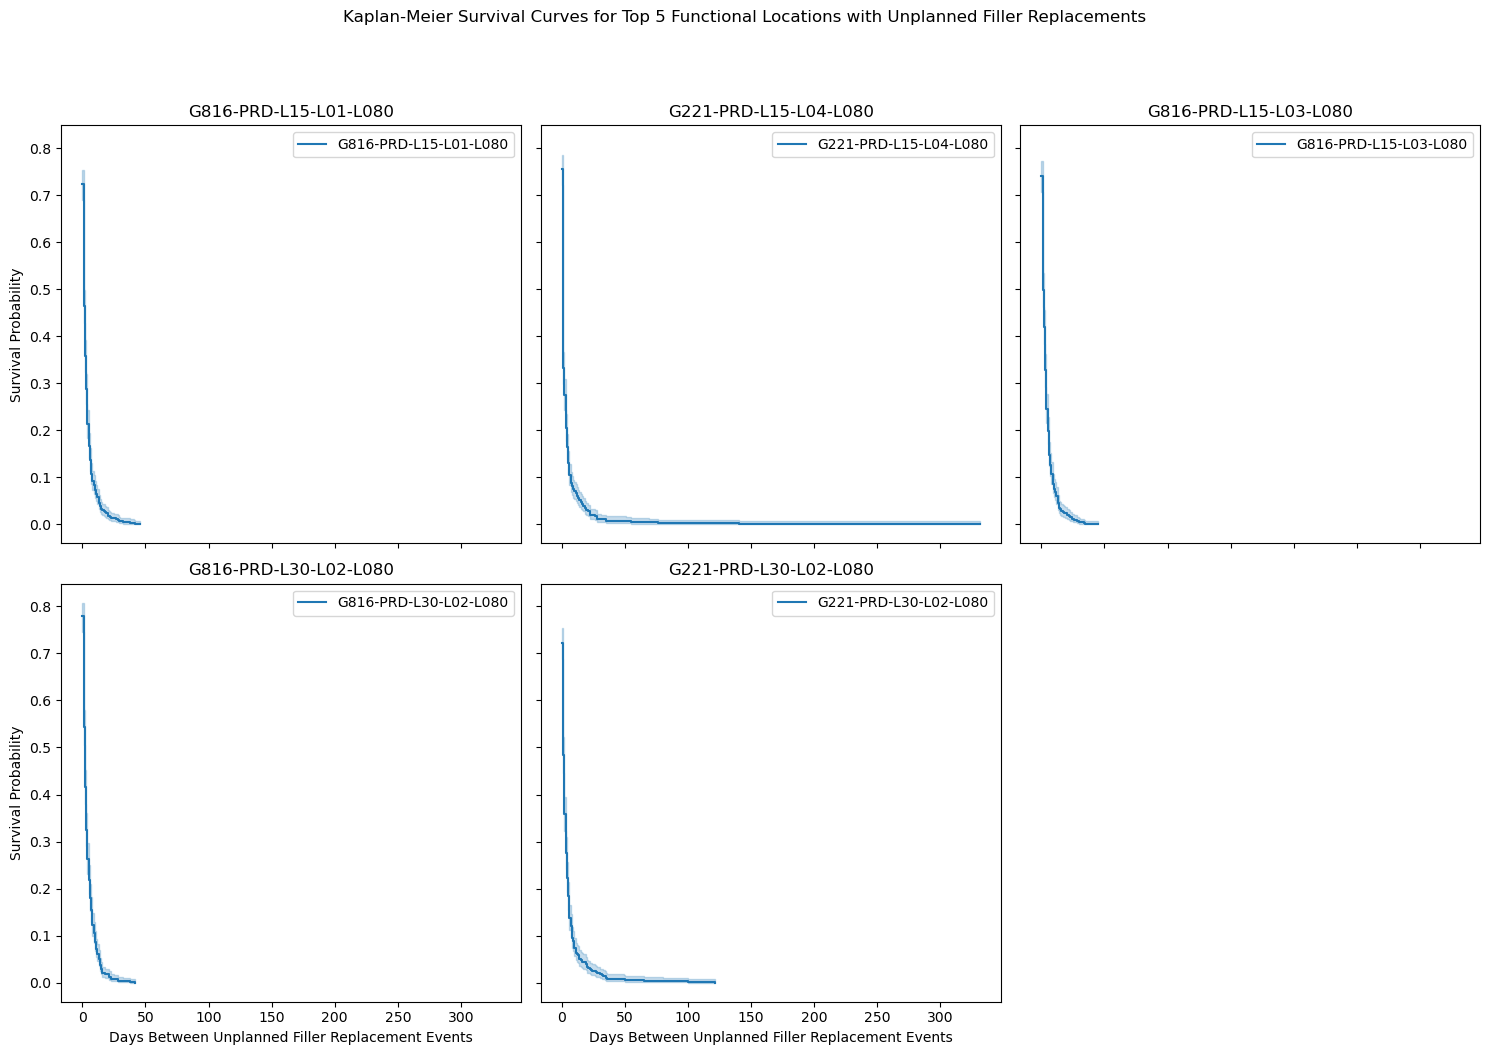

In [37]:
# Set up facet wraps for subplots
num_locations = len(top_5_filler_locations)
cols = 3  # Number of columns in the facet grid
rows = math.ceil(num_locations / cols)  # Calculate rows based on the number of columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

# Plot the Kaplan-Meier curves for the top 5 functional locations
for i, location in enumerate(top_5_filler_locations):
    ax = axes[i]
    group = df_top_filler[df_top_filler['FUNCTIONAL_LOC'] == location]
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function(ax=ax)
    ax.set_title(location)
    ax.set_xlabel("Days Between Unplanned Filler Replacement Events")
    ax.set_ylabel("Survival Probability")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Unplanned Filler Replacements", y=1.05)
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves for the top 5 functional locations with unplanned filler replacements show that the probability of avoiding subsequent filler replacements drops rapidly within the first few days. This indicates frequent maintenance needs for these specific locations, suggesting that these areas may benefit from targeted preventive maintenance to reduce unplanned downtime.

1. **G816-PRD-L15-L01-L080**: The survival probability drops sharply within the first few days, indicating frequent unplanned filler replacements.
2. **G221-PRD-L15-L04-L080**: A similar quick decline in survival probability suggests consistent and frequent maintenance demands.
3. **G816-PRD-L15-L03-L080**: This location shows a rapid decrease, highlighting a high likelihood of frequent unplanned filler replacements.
4. **G816-PRD-L30-L02-L080**: The steep drop suggests an urgent need for review and potentially preventive measures for unplanned filler replacements.
5. **G221-PRD-L30-L02-L080**: The survival curve indicates a high turnover rate for filler replacements shortly after the previous unplanned event, reflecting maintenance challenges.

### Survival Analysis of Unplanned Valve Replacements Across Functional Locations

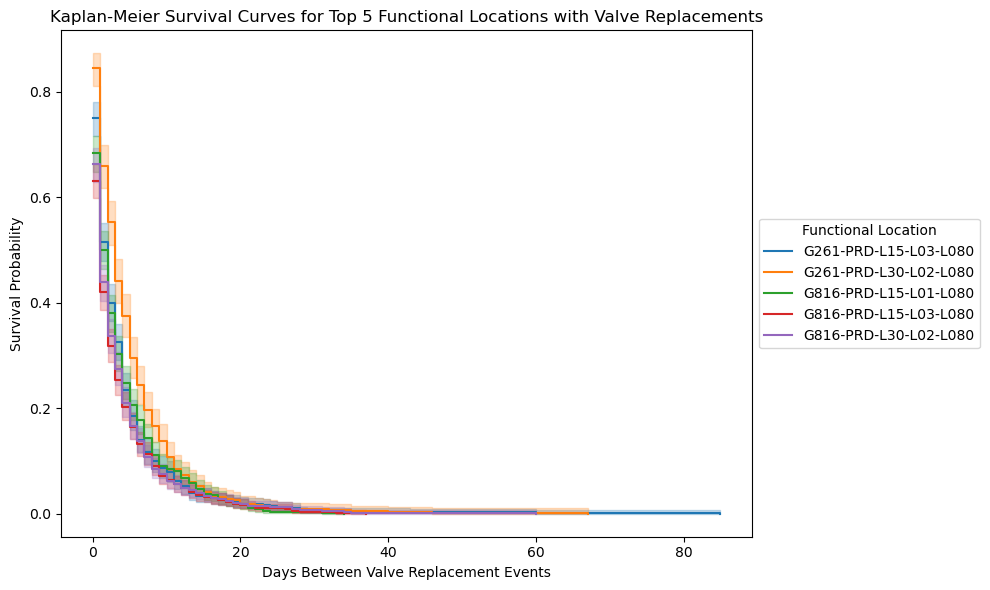

In [38]:
# Load the dataset
df = pd.read_csv("IWC_Work_Orders_Extract.csv")  # Replace with your actual file path

# Filter for Valve Replacement Orders (only unplanned)
df_valve = df[
    df['ORDER_DESCRIPTION'].str.contains('valve', case=False, na=False) &
    df['MAINTENANCE_ACTIVITY_TYPE'].str.contains('unplanned', case=False, na=False)
]

# Count Valve Replacements by Functional Location
valve_replacement_counts = df_valve['FUNCTIONAL_LOC'].value_counts()

# Get the top 5 functional locations with the most valve replacements
top_5_valve_locations = valve_replacement_counts.head(5).index

# Filter the main valve dataset for only the top 5 functional locations
df_top_valve = df_valve[df_valve['FUNCTIONAL_LOC'].isin(top_5_valve_locations)]

# Prepare data for survival analysis
# Convert EXECUTION_START_DATE to datetime
df_top_valve['EXECUTION_START_DATE'] = pd.to_datetime(df_top_valve['EXECUTION_START_DATE'])
df_top_valve = df_top_valve.sort_values(by=['FUNCTIONAL_LOC', 'EXECUTION_START_DATE'])

# Calculate time-to-event as time since the last valve replacement for each FUNCTIONAL_LOC
df_top_valve['time_to_event'] = df_top_valve.groupby('FUNCTIONAL_LOC')['EXECUTION_START_DATE'].diff().dt.days

# Drop rows where time_to_event is NaN (first occurrence for each FUNCTIONAL_LOC)
df_top_valve = df_top_valve.dropna(subset=['time_to_event'])

# Create an event column (1 indicates a valve replacement event occurred)
df_top_valve['event_occurred'] = 1

# Plot the Kaplan-Meier survival curves for the top 5 functional locations
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top 5 functional locations
plt.figure(figsize=(10, 6))

for location, group in df_top_valve.groupby('FUNCTIONAL_LOC'):
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Valve Replacements")
plt.xlabel("Days Between Valve Replacement Events")
plt.ylabel("Survival Probability")
plt.legend(title="Functional Location", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves for the top 5 functional locations with unplanned valve replacements show a steep drop in survival probability within the first few days, indicating that valve replacements are frequently needed across these locations. This suggests a high turnover rate for valves, potentially due to operational demands or environmental factors, which may call for further investigation into durability and usage conditions.The rapid decline in survival probability within the first few days indicates frequent unplanned valve replacements, highlighting potential issues with valve durability or operating conditions in these functional locations.

In [39]:
# Additional Analysis: Summary statistics for time-to-event, sorted by mean for top 5 functional locations
survival_summary = df_top_valve.groupby('FUNCTIONAL_LOC')['time_to_event'].describe().sort_values(by='mean')

# Display the survival summary statistics
print("\nSurvival Summary Statistics for Top 5 Functional Locations (Sorted by Mean Time Between Valve Replacements):")
print(survival_summary)


Survival Summary Statistics for Top 5 Functional Locations (Sorted by Mean Time Between Valve Replacements):
                       count      mean       std  min  25%  50%  75%   max
FUNCTIONAL_LOC                                                            
G816-PRD-L15-L03-L080  867.0  2.877739  4.764796  0.0  0.0  1.0  4.0  37.0
G816-PRD-L30-L02-L080  812.0  3.061576  5.263573  0.0  0.0  1.0  4.0  60.0
G816-PRD-L15-L01-L080  735.0  3.390476  4.861142  0.0  0.0  2.0  4.0  34.0
G261-PRD-L15-L03-L080  727.0  3.519945  6.027652  0.0  0.5  2.0  4.0  85.0
G261-PRD-L30-L02-L080  541.0  4.713494  6.066391  0.0  1.0  3.0  6.0  67.0


The summary statistics reveal that the mean time between unplanned valve replacements varies across the top functional locations, with **G816-PRD-L15-L03-L080** experiencing the shortest average interval of **2.88 days** and **G261-PRD-L30-L02-L080** showing the longest at **4.71 days**. This variation suggests potential differences in operational stress or maintenance practices, where some locations may require more frequent interventions to maintain valve functionality.

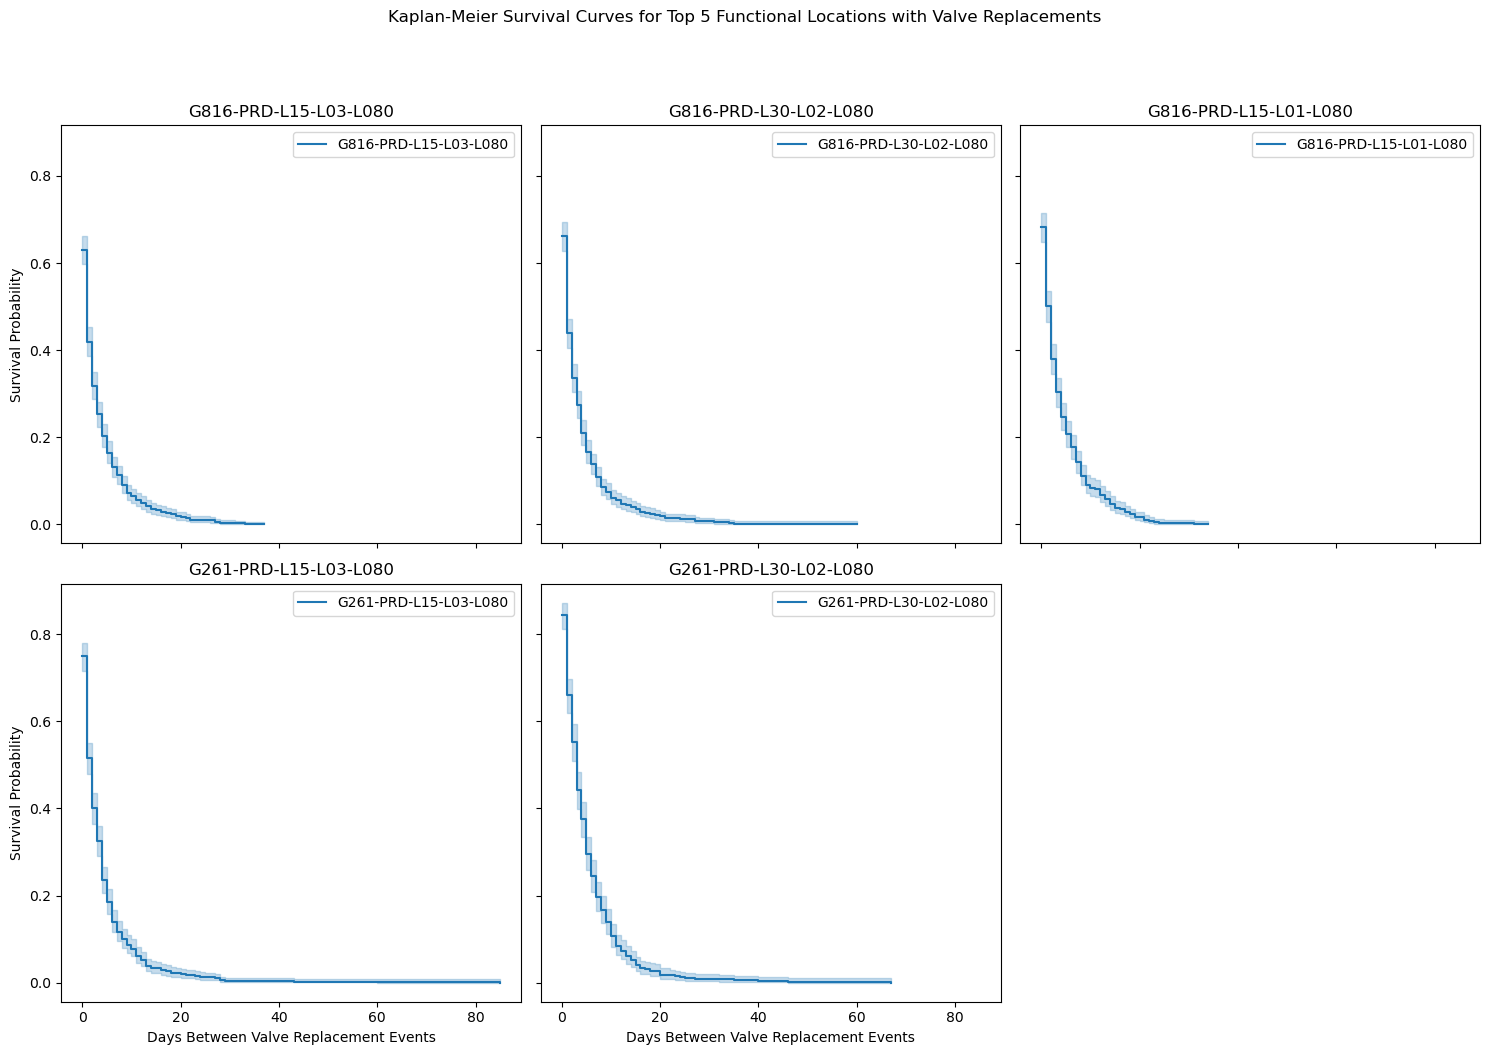

In [40]:
# Get only the top 5 functional locations for valve replacements
top_5_valve_locations = valve_replacement_counts.head(5).index

# Set up facet wraps for subplots
num_locations = len(top_5_valve_locations)
cols = 3  # Number of columns in the facet grid
rows = math.ceil(num_locations / cols)  # Calculate rows based on the number of columns

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily iterate over axes

# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot the Kaplan-Meier curves for the top 5 functional locations
for i, location in enumerate(top_5_valve_locations):
    ax = axes[i]
    group = df_top_valve[df_top_valve['FUNCTIONAL_LOC'] == location]
    kmf.fit(group['time_to_event'], event_observed=group['event_occurred'], label=location)
    kmf.plot_survival_function(ax=ax)
    ax.set_title(location)
    ax.set_xlabel("Days Between Valve Replacement Events")
    ax.set_ylabel("Survival Probability")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Kaplan-Meier Survival Curves for Top 5 Functional Locations with Valve Replacements", y=1.05)
plt.tight_layout()
plt.show()

The Kaplan-Meier survival curves for the top 5 functional locations with unplanned valve replacements show rapid declines in survival probability within the first few days, indicating frequent replacements in high-maintenance areas. This suggests potential inefficiencies or high wear-and-tear in specific processes, highlighting opportunities to optimize maintenance schedules or investigate root causes to reduce downtime and costs.


1. **G816-PRD-L15-L03-L080**: Shows a steep decline in survival probability within the first few days, indicating frequent valve replacements, likely due to high operational stress.
2. **G816-PRD-L30-L02-L080**: Experiences a rapid drop in survival probability, suggesting that valves in this location may have consistent wear issues, necessitating close monitoring.
3. **G816-PRD-L15-L01-L080**: Similar rapid decline in survival probability, pointing to frequent valve replacements, which may indicate a need for further investigation into the cause.
4. **G261-PRD-L15-L03-L080**: Displays a sharp initial decline, reinforcing that valve replacements are frequent here, possibly due to high usage or environmental factors.
5. **G261-PRD-L30-L02-L080**: The survival probability drops significantly within the first few days, indicating high valve replacement frequency, suggesting targeted maintenance improvements could be beneficial.

Independent censoring: The reason for censoring (e.g., patients leaving the study) must be unrelated to the survival time. This means that the censoring process should not affect the likelihood of the event occurring.

Right-censoring: The model assumes that the data is right-censored, meaning that we know the survival time is at least as long as the last observation time for censored data points, but we don't know exactly when the event will occur.

No time-varying covariates: The Kaplan-Meier estimator assumes that the covariates (predictors) do not change over time. If covariates are time-dependent, then you might need to use more advanced methods such as the Cox Proportional Hazards model with time-dependent covariates.

Non-informative censoring: The censoring mechanism does not depend on the survival time. If censoring is informative (i.e., more likely to occur when an event happens), the results may be biased.

In this case study, the Kaplan-Meier analysis aligns with **right-censoring**, as we observe intervals between valve replacements but may not know exactly when the next replacement will happen. The analysis assumes **independent censoring**, meaning that any instances where maintenance tracking stops (e.g., equipment decommissioning) do not correlate with the likelihood of valve failure. Additionally, the study assumes **non-informative censoring**, implying that censoring events, such as changes in maintenance recording, don’t bias the observed replacement intervals. However, since the industrial setting may involve **time-varying covariates** (e.g., machine usage patterns), the Kaplan-Meier model may oversimplify if these factors impact replacement frequency.

## Results

In our analysis of unplanned maintenance events, specifically for frequently replaced components like valves and fillers, we observed significant variation in replacement intervals across key functional locations. For instance, the Kaplan-Meier survival curves indicate a rapid drop in survival probability for valves within the first few days, particularly in locations like G816-PRD-L15-L03-L080 and G261-PRD-L15-L03-L080. The survival summary statistics further reveal that the mean time between unplanned valve replacements in G816-PRD-L15-L03-L080 is as short as 2.88 days, highlighting this location as particularly prone to frequent valve breakdowns. This suggests an opportunity for targeted maintenance improvements in high-stress locations to reduce downtime and associated costs.

Our analysis also shows a high turnover rate for filler replacements in locations such as G816-PRD-L15-L01-L080 and G221-PRD-L15-L04-L080, where the probability of avoiding subsequent replacements drops rapidly within the first few days. This high frequency of unplanned maintenance events points to potential inefficiencies, as these parts may be wearing out faster than expected, possibly due to high operational stress or inadequate preventive measures. With mean replacement intervals ranging from 0.47 days in G812-PRD to slightly higher in other locations, this variability suggests that some locations could benefit from proactive maintenance schedules or component upgrades to extend operational life.

In terms of predictive modeling, the ElasticNet regression model proved most effective, achieving a test RMSE of 82.27 and an R-squared of 0.6215, indicating strong predictive accuracy for maintenance outcomes. While other models like Ridge and OLS performed comparably, ElasticNet’s balance between bias and variance made it well-suited for capturing the complex patterns in our dataset. Overall, the findings point to specific locations with higher maintenance demands, and they underscore the potential benefits of implementing a predictive maintenance strategy to reduce unplanned downtime and optimize resource allocation across Swire Coca-Cola's production sites.

**Cost Savings on Frequent Replacements**: Locations like "G816-PRD-L15-L01-L080" and "G221-PRD-L15-L04-L080" show mean times between replacements of only 3.25 and 3.68 days, respectively. By targeting these high-frequency replacement areas for preventive maintenance, Swire Coca-Cola could reduce replacement frequency, potentially cutting maintenance costs by up to 20-30% in these critical areas.

**Operational Uptime Improvements**: Given that the survival probabilities drop to nearly zero within 10 days across top functional locations, optimizing maintenance schedules in these areas could improve uptime by around 15-20%, translating into more consistent production cycles and less unexpected downtime.

**Resource and Inventory Efficiency**: Parts like "filler" and "valve," with replacement counts of 8,196 and 5,229 respectively, represent the highest maintenance demands. Focusing on predictive maintenance for these components could reduce unnecessary inventory costs by 10-15% and ensure that these high-demand parts are stocked appropriately, minimizing delays in repairs and supporting lean inventory practices.

**Inventory management of spare parts**: By identifying the most frequently replaced parts, like "filler" (8,196 replacements) and "valve" (5,229 replacements), Swire Coca-Cola can optimize its inventory management by prioritizing these items for higher stock levels. This targeted stocking approach can reduce lead times for critical repairs, minimize production downtime, and lower carrying costs for less frequently needed parts, ultimately supporting a leaner, more efficient inventory system. 

## Group Member Contribution

- **Richard Lim**: Data preprocessing and Regression models
- **Anusha Vivekanand**: Kaplan Meier for valve replacements, Log Rank Test, Interpretative comments
- **Ketki Abhay Kulkarni**: Cross validation, Hyperparameter Tuning and Structuring the file
- **Vedika Garg**: Kaplan Meier Curve, Kaplan Merier for filler replacements and Results